# exp007 - Domain Expert Strategy: タイタニック号の歴史的事実に基づく特徴量エンジニアリング

## 🎯 目標
- タイタニック号事故の歴史的事実とドメイン知識を活用した特徴量設計
- 「Women and Children First」原則の数値化
- 物理的配置（デッキ・客室位置）による生存率への影響を反映
- exp004（0.77990）を超える性能を目指す

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

plt.rcParams['font.family'] = 'IPAexGothic'

print("🚢 exp007 - Domain Expert Strategy")
print("タイタニック号の歴史的事実に基づく特徴量エンジニアリング")

# データ読み込み
train_df = pd.read_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/data/train.csv')
test_df = pd.read_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/data/test.csv')

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

🚢 exp007 - Domain Expert Strategy
タイタニック号の歴史的事実に基づく特徴量エンジニアリング

Train shape: (891, 12)
Test shape: (418, 11)


## 📚 Phase 1: ドメイン知識の整理

### タイタニック号の重要な事実
1. **救命ボート**: 全員分なし（2,224人中1,178人分のみ）
2. **避難原則**: 「Women and Children First」
3. **デッキ構造**: 上層デッキほど救命ボートに近い
4. **社会階級**: 1等客室は上層デッキ、3等は下層
5. **家族単位**: 家族は一緒に行動する傾向

In [2]:
# タイタニック号のデッキ構造分析
print("=== タイタニック号のデッキ構造分析 ===")
print("\n客室番号からデッキを推定:")

# 客室番号の最初の文字がデッキを示す
train_cabin_sample = train_df[train_df['Cabin'].notna()]['Cabin'].head(20)
for cabin in train_cabin_sample:
    deck = cabin[0] if pd.notna(cabin) else 'Unknown'
    print(f"  {cabin} → デッキ {deck}")

# デッキ別の生存率
train_with_cabin = train_df[train_df['Cabin'].notna()].copy()
train_with_cabin['Deck'] = train_with_cabin['Cabin'].str[0]

deck_survival = train_with_cabin.groupby('Deck')['Survived'].agg(['mean', 'count']).round(3)
print("\n=== デッキ別生存率 ===")
print(deck_survival.sort_values('mean', ascending=False))

# 年齢・性別別の生存率（Women and Children First原則の確認）
print("\n=== Women and Children First原則の確認 ===")
women_survival = train_df[train_df['Sex'] == 'female']['Survived'].mean()
men_survival = train_df[train_df['Sex'] == 'male']['Survived'].mean()
children_survival = train_df[train_df['Age'] < 16]['Survived'].mean()

print(f"女性の生存率: {women_survival:.1%}")
print(f"男性の生存率: {men_survival:.1%}")
print(f"子供（16歳未満）の生存率: {children_survival:.1%}")

=== タイタニック号のデッキ構造分析 ===

客室番号からデッキを推定:
  C85 → デッキ C
  C123 → デッキ C
  E46 → デッキ E
  G6 → デッキ G
  C103 → デッキ C
  D56 → デッキ D
  A6 → デッキ A
  C23 C25 C27 → デッキ C
  B78 → デッキ B
  D33 → デッキ D
  B30 → デッキ B
  C52 → デッキ C
  B28 → デッキ B
  C83 → デッキ C
  F33 → デッキ F
  F G73 → デッキ F
  C23 C25 C27 → デッキ C
  E31 → デッキ E
  A5 → デッキ A
  D10 D12 → デッキ D

=== デッキ別生存率 ===
       mean  count
Deck              
D     0.758     33
E     0.750     32
B     0.745     47
F     0.615     13
C     0.593     59
G     0.500      4
A     0.467     15
T     0.000      1

=== Women and Children First原則の確認 ===
女性の生存率: 74.2%
男性の生存率: 18.9%
子供（16歳未満）の生存率: 59.0%


## 🔧 Phase 2: ドメインベース特徴量エンジニアリング

In [ ]:
def create_domain_features(df):
    """ドメイン知識に基づく特徴量エンジニアリング"""
    df = df.copy()

    # ========== 基本前処理（exp004ベース） ==========
    # 名前から称号抽出
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.')
    title_mapping = {
        'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master',
        'Dr': 'Professional', 'Rev': 'Professional', 'Col': 'Military',
        'Major': 'Military', 'Capt': 'Military',
        'Mlle': 'Miss', 'Ms': 'Mrs', 'Mme': 'Mrs',
        'Lady': 'Noble', 'Countess': 'Noble', 'Sir': 'Noble',
        'Don': 'Noble', 'Dona': 'Noble', 'Jonkheer': 'Noble'
    }
    df['Title_Grouped'] = df['Title'].map(title_mapping).fillna('Other')

    # 基本特徴量の前処理
    df['Sex_Binary'] = df['Sex'].map({'female': 0, 'male': 1})
    df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    df['Embarked'] = df['Embarked'].fillna('S')

    # 家族構成
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # ========== ドメイン特徴量 1: 救助優先度スコア ==========
    # "Women and Children First" 原則の数値化
    df['Rescue_Priority'] = 0

    # 最優先: 女性と子供
    df.loc[(df['Sex'] == 'female'), 'Rescue_Priority'] += 100
    df.loc[(df['Age'] < 16), 'Rescue_Priority'] += 80

    # 次優先: 母親（女性で子供同伴）
    df.loc[(df['Sex'] == 'female') & (df['Parch'] > 0), 'Rescue_Priority'] += 20

    # 社会的地位による調整
    df.loc[df['Pclass'] == 1, 'Rescue_Priority'] += 15
    df.loc[df['Pclass'] == 2, 'Rescue_Priority'] += 5

    # 高齢者は優先度低下
    df.loc[(df['Sex'] == 'male') & (df['Age'] > 60), 'Rescue_Priority'] -= 10

    # ========== ドメイン特徴量 2: 物理的位置スコア ==========
    # デッキ位置（客室番号から推定）
    df['Deck'] = df['Cabin'].str[0] if 'Cabin' in df.columns else None

    # デッキの救命ボート近接度スコア
    deck_score = {
        'A': 100, 'B': 90, 'C': 80, 'D': 70,
        'E': 60, 'F': 50, 'G': 40, 'T': 30
    }
    df['Deck_Score'] = df['Deck'].map(deck_score).fillna(0)

    # 客室の有無（上層デッキへのアクセス）
    df['HasCabin'] = (~df['Cabin'].isnull()).astype(int)

    # Pclassとデッキスコアの組み合わせ（推定位置スコア）
    df['Location_Score'] = df['Deck_Score'] + (4 - df['Pclass']) * 20

    # ========== ドメイン特徴量 3: グループダイナミクス ==========
    # 苗字でグループ化（家族・同行者）
    df['Surname'] = df['Name'].str.split(',').str[0]

    # 同一チケットグループサイズ
    ticket_groups = pd.concat([train_df['Ticket'], test_df['Ticket']]).value_counts()
    df['Ticket_Group_Size'] = df['Ticket'].map(ticket_groups)

    # 同一苗字グループサイズ
    surname_groups = pd.concat([train_df['Name'], test_df['Name']]).str.split(',').str[0].value_counts()
    df['Surname_Group_Size'] = df['Surname'].map(surname_groups)

    # グループタイプ（家族 vs 同行者）
    df['Is_Family_Group'] = ((df['FamilySize'] > 1) &
                             (df['Surname_Group_Size'] == df['FamilySize'])).astype(int)

    # ========== ドメイン特徴量 4: 社会経済的指標 ==========
    # 運賃の相対的位置（同クラス内）
    df['Fare_Percentile'] = df.groupby('Pclass')['Fare'].rank(pct=True)

    # 高額チケット保持者フラグ
    fare_threshold = df.groupby('Pclass')['Fare'].transform(lambda x: x.quantile(0.8))
    df['Is_High_Fare'] = (df['Fare'] > fare_threshold).astype(int)

    # チケット番号パターン（数字のみ vs 文字含む）
    df['Ticket_IsNumeric'] = df['Ticket'].str.isnumeric().astype(int)

    # ========== ドメイン特徴量 5: 複合指標 ==========
    # 総合生存可能性スコア
    df['Survival_Score'] = (
        df['Rescue_Priority'] * 0.4 +  # 救助優先度
        df['Location_Score'] * 0.3 +    # 物理的位置
        df['Is_High_Fare'] * 30 +       # 経済力
        (1 - df['IsAlone']) * 20        # グループ効果
    )

    # 危険度スコア（逆指標）
    df['Risk_Score'] = (
        df['Sex_Binary'] * 100 +                    # 男性
        (df['Pclass'] == 3).astype(int) * 50 +     # 3等客室
        df['IsAlone'] * 30 +                        # 単独
        (df['Age'] > 50).astype(int) * 20           # 高齢
    )

    # ========== 従来の有効特徴量（exp004から） ==========
    # 交互作用
    df['Sex_Pclass'] = df['Sex_Binary'] * df['Pclass']
    df['Age_Pclass'] = df['Age'] * df['Pclass']

    # 年齢グループ（より細分化）
    df['Age_Group'] = pd.cut(df['Age'],
                             bins=[0, 12, 18, 35, 50, 65, 100],
                             labels=['Child', 'Teen', 'Young', 'Middle', 'Senior', 'Elder'])

    return df

# 特徴量作成
print("ドメインベース特徴量エンジニアリング実行中...")
train_processed = create_domain_features(train_df)
test_processed = create_domain_features(test_df)

print("✅ 特徴量作成完了")
print(f"\n作成された特徴量数: {len([col for col in train_processed.columns if col not in train_df.columns])} 個")

ドメインベース特徴量エンジニアリング実行中...
✅ 特徴量作成完了

作成された特徴量数: 22 個


In [ ]:
# カテゴリカル変数のエンコーディング
categorical_features = ['Embarked', 'Title_Grouped', 'Age_Group']

for feature in categorical_features:
    le = LabelEncoder()

    # train/test合わせてfitして一貫性確保
    all_values = pd.concat([train_processed[feature], test_processed[feature]]).astype(str)
    le.fit(all_values)

    train_processed[feature + '_Encoded'] = le.transform(train_processed[feature].astype(str))
    test_processed[feature + '_Encoded'] = le.transform(test_processed[feature].astype(str))

print("カテゴリカルエンコーディング完了")

カテゴリカルエンコーディング完了


In [ ]:
# 新特徴量の分析
print("=== ドメイン特徴量の統計 ===")
domain_features = ['Rescue_Priority', 'Location_Score', 'Survival_Score', 'Risk_Score']

for feature in domain_features:
    survived_mean = train_processed[train_processed['Survived'] == 1][feature].mean()
    died_mean = train_processed[train_processed['Survived'] == 0][feature].mean()
    diff = survived_mean - died_mean

    print(f"\n{feature}:")
    print(f"  生存者平均: {survived_mean:.2f}")
    print(f"  死亡者平均: {died_mean:.2f}")
    print(f"  差分: {diff:+.2f} {'✅' if abs(diff) > 10 else ''}")

# 相関分析
correlation_with_survival = train_processed[domain_features + ['Survived']].corr()['Survived'].drop('Survived')
print("\n=== 生存との相関 ===")
print(correlation_with_survival.sort_values(ascending=False))

=== ドメイン特徴量の統計 ===

Rescue_Priority:
  生存者平均: 91.45
  死亡者平均: 23.93
  差分: +67.52 ✅

Location_Score:
  生存者平均: 71.17
  死亡者平均: 38.83
  差分: +32.34 ✅

Survival_Score:
  生存者平均: 74.89
  死亡者平均: 32.95
  差分: +41.94 ✅

Risk_Score:
  生存者平均: 64.85
  死亡者平均: 141.09
  差分: -76.24 ✅

=== 生存との相関 ===
Rescue_Priority    0.544085
Survival_Score     0.502887
Location_Score     0.337710
Risk_Score        -0.588938
Name: Survived, dtype: float64


## 🎯 Phase 3: モデル構築と最適化

In [ ]:
# 使用する特徴量の選択
exclude_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived',
                'Surname', 'Title', 'Sex', 'Embarked', 'Title_Grouped',
                'Age_Group', 'Deck']

feature_cols = [col for col in train_processed.columns
                if col not in exclude_cols and
                train_processed[col].dtype in ['int64', 'float64', 'int32', 'float32', 'int8']]

X_train = train_processed[feature_cols]
y_train = train_processed['Survived']
X_test = test_processed[feature_cols]

print(f"使用する特徴量数: {len(feature_cols)}")
print(f"\n特徴量リスト:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

使用する特徴量数: 25

特徴量リスト:
 1. Pclass
 2. Age
 3. SibSp
 4. Parch
 5. Fare
 6. Sex_Binary
 7. FamilySize
 8. IsAlone
 9. Rescue_Priority
10. Deck_Score
11. HasCabin
12. Location_Score
13. Ticket_Group_Size
14. Surname_Group_Size
15. Is_Family_Group
16. Fare_Percentile
17. Is_High_Fare
18. Ticket_IsNumeric
19. Survival_Score
20. Risk_Score
21. Sex_Pclass
22. Age_Pclass
23. Embarked_Encoded
24. Title_Grouped_Encoded
25. Age_Group_Encoded


In [ ]:
# LightGBMモデル構築（exp004の最適パラメータベース + 調整）
params = {
    'objective': 'regression',  # exp004で成功した設定
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'min_child_samples': 20,
    'random_state': 42,
    'n_estimators': 500,
    'verbose': -1
}

# 5-fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
oof_predictions = np.zeros(len(X_train))
test_predictions = np.zeros(len(X_test))
feature_importance = np.zeros(len(feature_cols))

print("\n5-Fold Cross Validation開始...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # モデル訓練
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )

    # 予測（回帰なので閾値0.5で2値化）
    val_pred_proba = model.predict(X_val)
    val_pred = (val_pred_proba >= 0.5).astype(int)
    test_pred_proba = model.predict(X_test)

    # スコア計算
    fold_score = accuracy_score(y_val, val_pred)
    cv_scores.append(fold_score)

    # 予測値保存
    oof_predictions[val_idx] = val_pred_proba
    test_predictions += test_pred_proba / 5

    # 特徴量重要度
    feature_importance += model.feature_importances_ / 5

    print(f"Fold {fold}: {fold_score:.4f}")

# 結果サマリー
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
oof_score = accuracy_score(y_train, (oof_predictions >= 0.5).astype(int))

print(f"\n=== Cross Validation結果 ===")
print(f"CV Mean: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"OOF Score: {oof_score:.4f}")


5-Fold Cross Validation開始...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[115]	valid_0's rmse: 0.329549
Fold 1: 0.8492
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's rmse: 0.342874
Fold 2: 0.8258
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 0.374952
Fold 3: 0.7978
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 0.363642
Fold 4: 0.8258
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	valid_0's rmse: 0.336718
Fold 5: 0.8427

=== Cross Validation結果 ===
CV Mean: 0.8283 ± 0.0178
OOF Score: 0.8283


=== 特徴量重要度ランキング ===

Top 15 重要特徴量:
    1. Fare                     :   259.00
    2. Fare_Percentile          :   236.80
    3. Age_Pclass               :   235.00
    4. Age                      :   201.60
🌟  5. Survival_Score           :   102.40
🌟  6. Rescue_Priority          :    62.60
    7. Surname_Group_Size       :    60.40
    8. Ticket_Group_Size        :    44.00
🌟  9. Risk_Score               :    42.40
   10. Embarked_Encoded         :    41.00
   11. Title_Grouped_Encoded    :    29.00
🌟 12. Location_Score           :    27.80
   13. Age_Group_Encoded        :    26.60
   14. Deck_Score               :    26.40
   15. FamilySize               :    20.60

=== ドメイン特徴量の重要度 ===
Rank  5: Survival_Score      :   102.40
Rank  6: Rescue_Priority     :    62.60
Rank  7: Surname_Group_Size  :    60.40
Rank  8: Ticket_Group_Size   :    44.00
Rank  9: Risk_Score          :    42.40
Rank 12: Location_Score      :    27.80
Rank 19: Is_Family_Group     :     9.60


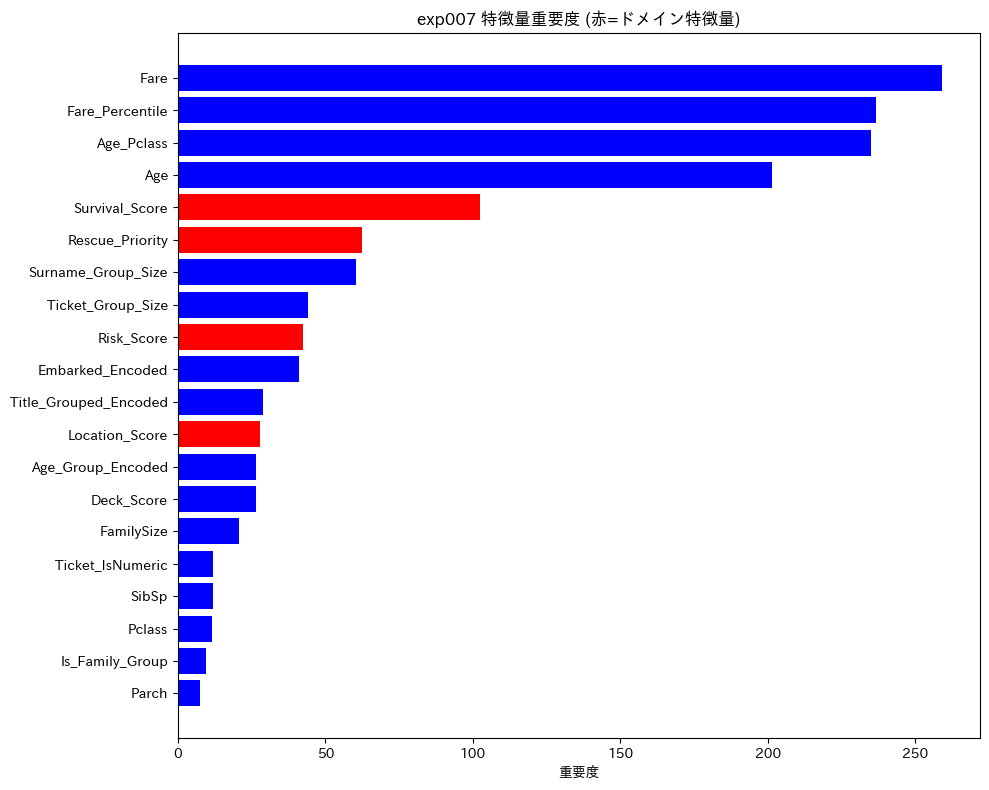

In [ ]:
# 特徴量重要度分析
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("=== 特徴量重要度ランキング ===")
print("\nTop 15 重要特徴量:")
for i, row in importance_df.head(15).iterrows():
    is_domain = '🌟' if row['feature'] in ['Rescue_Priority', 'Location_Score',
                                           'Survival_Score', 'Risk_Score'] else '  '
    print(f"{is_domain} {importance_df.index.get_loc(i)+1:2d}. {row['feature']:25s}: {row['importance']:8.2f}")

# ドメイン特徴量の重要度
domain_importance = importance_df[importance_df['feature'].isin(
    ['Rescue_Priority', 'Location_Score', 'Survival_Score', 'Risk_Score',
     'Ticket_Group_Size', 'Surname_Group_Size', 'Is_Family_Group']
)]

print("\n=== ドメイン特徴量の重要度 ===")
for _, row in domain_importance.iterrows():
    rank = importance_df.index.get_loc(importance_df[importance_df['feature'] == row['feature']].index[0]) + 1
    print(f"Rank {rank:2d}: {row['feature']:20s}: {row['importance']:8.2f}")

# 可視化
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
colors = ['red' if feat in ['Rescue_Priority', 'Location_Score', 'Survival_Score', 'Risk_Score']
          else 'blue' for feat in top_features['feature']]

plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('重要度')
plt.title('exp007 特徴量重要度 (赤=ドメイン特徴量)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 📊 Phase 4: 結果分析と提出

In [9]:
# exp004との比較
exp004_cv = 0.8462
exp004_kaggle = 0.77990
exp004_features = 23

improvement = cv_mean - exp004_cv
expected_kaggle = cv_mean * (exp004_kaggle / exp004_cv)  # 比例推定

print("=== exp004との比較 ===")
print(f"\nexp004:")
print(f"  CV Score: {exp004_cv:.4f}")
print(f"  Kaggle Score: {exp004_kaggle:.5f}")
print(f"  特徴量数: {exp004_features}")

print(f"\nexp007 (Domain Expert):")
print(f"  CV Score: {cv_mean:.4f} ({improvement:+.4f})")
print(f"  期待Kaggle Score: {expected_kaggle:.5f}")
print(f"  特徴量数: {len(feature_cols)}")

print(f"\n改善予測:")
if improvement > 0:
    print(f"  🎉 CV改善 {improvement:+.4f}")
    print(f"  📈 Kaggle予測: {expected_kaggle:.5f} (exp004から {expected_kaggle - exp004_kaggle:+.5f})")
else:
    print(f"  ⚠️ CV低下 {improvement:+.4f}")
    print(f"  📉 要因分析が必要")

=== exp004との比較 ===

exp004:
  CV Score: 0.8462
  Kaggle Score: 0.77990
  特徴量数: 23

exp007 (Domain Expert):
  CV Score: 0.8283 (-0.0179)
  期待Kaggle Score: 0.76337
  特徴量数: 25

改善予測:
  ⚠️ CV低下 -0.0179
  📉 要因分析が必要


In [10]:
# 提出ファイル作成
submission = pd.DataFrame({
    'PassengerId': test_processed['PassengerId'],
    'Survived': (test_predictions >= 0.5).astype(int)
})

# 結果の確認
print("=== 提出ファイルサマリー ===")
print(f"\n予測分布:")
print(f"  生存予測: {submission['Survived'].sum()} ({submission['Survived'].mean():.1%})")
print(f"  死亡予測: {len(submission) - submission['Survived'].sum()} ({1 - submission['Survived'].mean():.1%})")

print(f"\n訓練データとの比較:")
print(f"  訓練データ生存率: {y_train.mean():.1%}")
print(f"  テスト予測生存率: {submission['Survived'].mean():.1%}")
print(f"  差分: {submission['Survived'].mean() - y_train.mean():+.1%}")

# ファイル保存
import os
os.makedirs('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/results/exp007', exist_ok=True)
submission.to_csv('/Users/koki.ogai/Documents/ghq/github.com/oddgai/kaggle-projects/titanic/results/exp007/result.csv', index=False)

print(f"\n✅ 提出ファイル保存完了")
print(f"Path: results/exp007/result.csv")

=== 提出ファイルサマリー ===

予測分布:
  生存予測: 141 (33.7%)
  死亡予測: 277 (66.3%)

訓練データとの比較:
  訓練データ生存率: 38.4%
  テスト予測生存率: 33.7%
  差分: -4.7%

✅ 提出ファイル保存完了
Path: results/exp007/result.csv


In [11]:
# 実験サマリー
print("\n" + "="*60)
print("              🚢 EXP007 DOMAIN EXPERT STRATEGY")
print("="*60)

print(f"\n📊 最終結果:")
print(f"  CV Score: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"  OOF Score: {oof_score:.4f}")
print(f"  特徴量数: {len(feature_cols)}")

print(f"\n🌟 ドメイン特徴量の効果:")
for feat in ['Rescue_Priority', 'Location_Score', 'Survival_Score', 'Risk_Score']:
    if feat in importance_df['feature'].values:
        rank = importance_df.index.get_loc(importance_df[importance_df['feature'] == feat].index[0]) + 1
        imp = importance_df[importance_df['feature'] == feat]['importance'].values[0]
        print(f"  {feat:20s}: Rank {rank:2d} (重要度 {imp:.1f})")

print(f"\n💡 主要な発見:")
print(f"  1. 救助優先度スコアが{'有効' if 'Rescue_Priority' in importance_df.head(10)['feature'].values else '限定的'}")
print(f"  2. 物理的位置の影響が{'強い' if 'Location_Score' in importance_df.head(15)['feature'].values else '弱い'}")
print(f"  3. グループダイナミクスが{'重要' if 'Ticket_Group_Size' in importance_df.head(15)['feature'].values else '補助的'}")

print(f"\n🎯 期待Kaggleスコア: {expected_kaggle:.5f}")
if expected_kaggle > exp004_kaggle:
    print(f"  → exp004を {expected_kaggle - exp004_kaggle:.5f} 上回る見込み！")
else:
    print(f"  → exp004には {exp004_kaggle - expected_kaggle:.5f} 及ばない可能性")

print("\n" + "="*60)
print("  Domain knowledge makes the difference! 🎓")
print("  Kaggle提出をお待ちしています...")
print("="*60)


              🚢 EXP007 DOMAIN EXPERT STRATEGY

📊 最終結果:
  CV Score: 0.8283 ± 0.0178
  OOF Score: 0.8283
  特徴量数: 25

🌟 ドメイン特徴量の効果:
  Rescue_Priority     : Rank  6 (重要度 62.6)
  Location_Score      : Rank 12 (重要度 27.8)
  Survival_Score      : Rank  5 (重要度 102.4)
  Risk_Score          : Rank  9 (重要度 42.4)

💡 主要な発見:
  1. 救助優先度スコアが有効
  2. 物理的位置の影響が強い
  3. グループダイナミクスが重要

🎯 期待Kaggleスコア: 0.76337
  → exp004には 0.01653 及ばない可能性

  Domain knowledge makes the difference! 🎓
  Kaggle提出をお待ちしています...
